## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
import keras
import keras.utils

## Loading the dataset

In [2]:
data_dir = pathlib.Path('data')

In [3]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

2515


There are a total of 2515 images in the dataset

## Displaying a few images

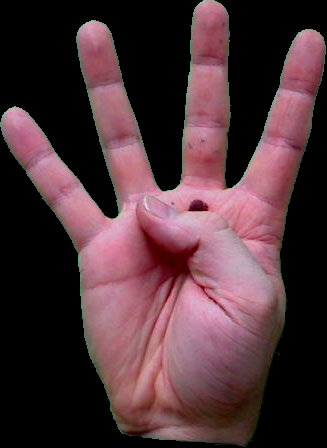

In [4]:
four = list(data_dir.glob('4/*'))
PIL.Image.open(str(four[0]))

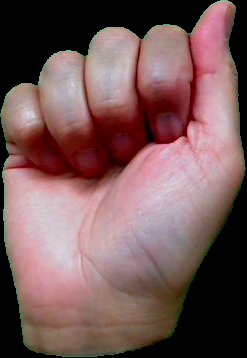

In [5]:
a = list(data_dir.glob('a/*'))
PIL.Image.open(str(a[0]))

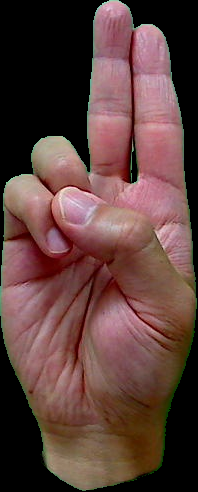

In [6]:
u = list(data_dir.glob('u/*'))
PIL.Image.open(str(u[0]))

### Defining parameters

In [7]:
batch_size = 32
img_height = 224
img_width = 224

## Splitting the dataset (80/20)

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2515 files belonging to 36 classes.
Using 2012 files for training.
Metal device set to: Apple M1


2022-11-08 19:42:13.542958: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-08 19:42:13.543073: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2515 files belonging to 36 classes.
Using 503 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Visualise the data

First 9 images in the training dataset

2022-11-08 19:42:22.314573: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


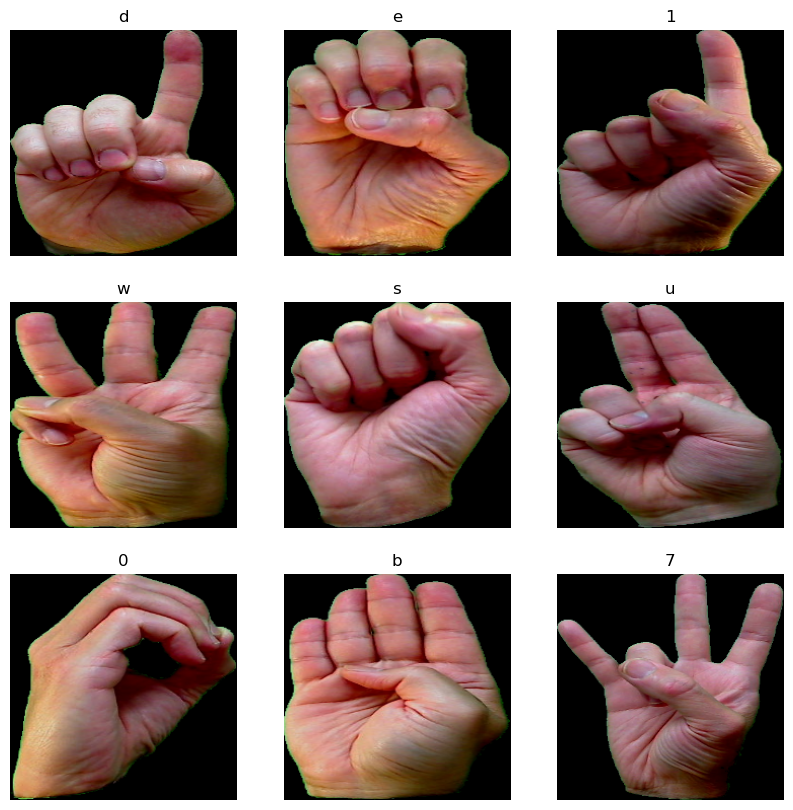

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Retrieve batches of images

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


Batch of 32 images of shape (224,224,3)

### Configure the dataset for performance

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardise the data

Standardise values to be in the `[0, 1]` range

In [14]:
normalization_layer = layers.Rescaling(1./255)

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[1]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99958974


## Creating the model

In [16]:
num_classes = len(class_names)
IMAGE_SIZE = [img_height, img_width]

vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Not training the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False
    
x = Flatten()(vgg.output)
prediction = Dense(36, activation='softmax')(x) # softmax is used as it is a multiclass classification
model = Model(inputs=vgg.input, outputs=prediction)

### Model Summary

View the structure of the model

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Compile the model

In [18]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

### Train the model

In [19]:
epochs=10
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/10


2022-11-08 19:42:58.116175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - ETA: 0s - loss: 6.1743 - accuracy: 0.8086

2022-11-08 19:43:38.223777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 51s 803ms/step - loss: 6.1743 - accuracy: 0.8086 - val_loss: 1.0613 - val_accuracy: 0.9264
Epoch 2/10
63/63 [==============================] - 51s 808ms/step - loss: 0.5716 - accuracy: 0.9697 - val_loss: 0.2834 - val_accuracy: 0.9821
Epoch 3/10
63/63 [==============================] - 52s 826ms/step - loss: 0.3785 - accuracy: 0.9846 - val_loss: 0.4583 - val_accuracy: 0.9742
Epoch 4/10
63/63 [==============================] - 54s 856ms/step - loss: 0.1552 - accuracy: 0.9916 - val_loss: 0.4286 - val_accuracy: 0.9821
Epoch 5/10
63/63 [==============================] - 55s 870ms/step - loss: 0.1529 - accuracy: 0.9916 - val_loss: 0.7588 - val_accuracy: 0.9761
Epoch 6/10
63/63 [==============================] - 55s 872ms/step - loss: 0.1676 - accuracy: 0.9940 - val_loss: 0.6650 - val_accuracy: 0.9722
Epoch 7/10
63/63 [==============================] - 55s 883ms/step - loss: 0.1850 - accuracy: 0.9925 - val_loss: 0.8316 - val_accuracy: 0.9622
Epoch 8/10

## Visualise training results

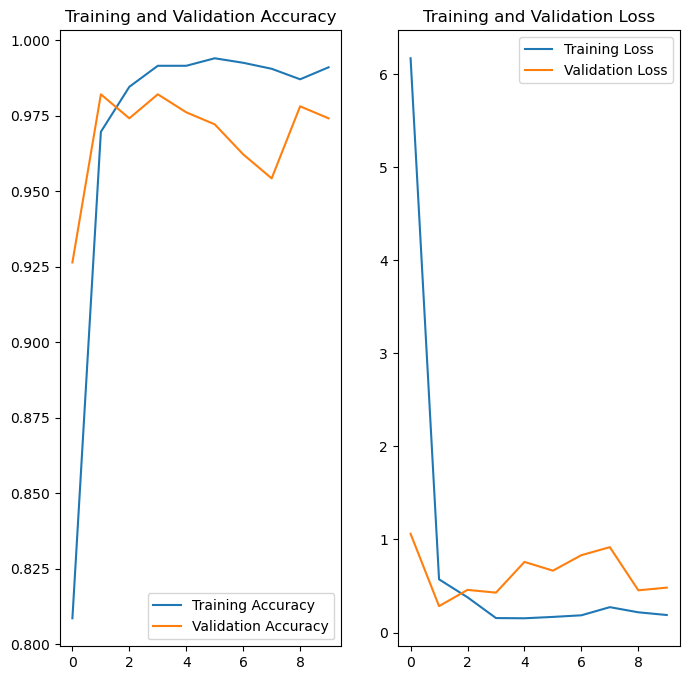

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
model.save('saved_model.h5')

In [22]:
# load and prepare the image
def load_image(filename):
    # load the image
    img = load_img(filename, target_size=(224, 224))
    # convert to array
    img = img_to_array(img)
    # reshape into a single sample with 3 channels
    img = img.reshape(1, 224, 224, 3)
    # prepare pixel data
    img = img.astype('float32')
    img = img / 255.0
    return img

In [29]:
# load the image
img = load_image('uploads/nine.jpeg')
# load model
model = load_model('saved_model.h5')
# predict the class
# result = model.predict_classes(img)
# result = (model.predict(img) > 0.5).astype("int32")
#Defining the class labels
CLASSES=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 
            'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
y_predict = CLASSES[np.argmax(model.predict(img))]
print(y_predict)

1/1 [==============================] - 0s 115ms/step
n


2022-11-08 19:57:08.678591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [ ]:
# make class predictions with the model
predictions = (model.predict(train_ds) > 0.5).astype(int)
# summarize the first 5 cases
for i in range(5):
	print('%s => %d (expected %d)' % (X[i].tolist(), predictions[i], y[i]))

## Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator( 
        rotation_range=10,  
        zoom_range = 0.1,  
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=False,  
        vertical_flip=False)  

train_ds = train_datagen.flow_from_directory(train_ds,
                                             target_size = (224, 224),
                                             batch_size = 32,
                                             class_mode = 'categorical')